# Preambulo

## Librerías

In [ ]:
  !pip install xgboost shap pandas scikit-learn lime scikit-optimize --quiet

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import shap

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lime
import lime.lime_tabular

import time


### Configuración global de XGBoost

In [ ]:
xgb.set_config(verbosity=1) # 0 (silent), 1 (warning), 2 (info), and 3 (debug).

## Datos

El dataset se encuentra disponible en la página web: [Virtual Reality Immersion Dataset, Mendeley Data (https://data.mendeley.com/datasets/kj79vpcsc5/2)](https://data.mendeley.com/datasets/kj79vpcsc5/2).

In [ ]:
file_id = "1GU0UNB4a2kg8JqSXaTz0X6Gf7cS2u52K"
url = f"https://drive.google.com/uc?id={file_id}"

nombre_csv="dataset.csv"

try:
    df = pd.read_csv(url, sep=';')
    print("✅ CSV cargado exitosamente.")
except FileNotFoundError:
    print(f"❓ Error: El archivo '{nombre_csv}' no se encontró en la ruta '.\n")
except Exception as e:
    print(f"❌ Ocurrió un error al cargar el archivo .csv: {e}.\n")

✅ CSV cargado exitosamente.


# Desarrollo

## Preparación de datos

In [ ]:
df.head()

,headphones,width,height,fov,fps,stereopsis,antialiasing,textures,lightMode,saturation,...,reflections,modelsDetail,dof,particles,locomotion,ambientSound,reverbZone,spatialSound,time,totalImmersion
0,1,1641.3370,911.8539,37,60,1,1,1,0,-0.450232,...,1,0,0,1,3,0,1,1,1196,80
1,1,1282.1180,712.2877,39,55,1,1,1,1,-0.234574,...,1,1,1,1,1,1,1,0,1194,82
2,1,1795.5310,997.5171,40,47,1,1,0,1,-0.551438,...,1,0,0,0,1,1,1,0,1196,44
3,2,838.4885,465.8270,44,48,0,0,1,0,-0.832656,...,1,0,1,0,3,0,0,0,1197,77
4,2,1924.7020,1069.2790,85,35,1,1,1,1,-0.376218,...,1,0,0,0,2,1,0,1,600,66


In [ ]:
X = df.drop(columns=['totalImmersion'])  # dataframe origianl, eliminando la columna con la etiqueta a predecir
y = df['totalImmersion'] # Solo columna con datos a predecir del dataset original

In [ ]:
media_totalImmersion = df['totalImmersion'].mean()
desviacion_totalImmersion = df['totalImmersion'].std()

print(f"Media aritmética de totalImmersion: {media_totalImmersion}")
print(f"Desviación estándar de totalImmersion: {desviacion_totalImmersion}")

Media aritmética de totalImmersion: 40.50374064837905
Desviación estándar de totalImmersion: 18.790306303319504


In [ ]:
# Se dividen los datos para entrenar(80% de los datos) y para testear(20% de los datos) con semilla aleatoria=42
# Los datos se separan antes de escalar, para que la media y varianza de los datos de prueba no influencien en el set de entrenamiento, sin embargo se escalan ambos con la media y varianza del set de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDatos divididos: {X_train.shape[0]} para entrenamiento, {X_test.shape[0]} para prueba.")


Datos divididos: 320 para entrenamiento, 81 para prueba.


In [ ]:
scaler = StandardScaler() # Se crea un Standard Scaler para poder escalar los datos

X_train_scaled = scaler.fit_transform(X_train)# Se ajustan y escalan los datos de entrenamiento mediante el Standard Scaler, quedando con media=0 y varianza=1
X_test_scaled = scaler.transform(X_test)# Se escalan los datos de prueba con la escala de los datos de entrenamiento

In [ ]:
y_train.head()

,totalImmersion
18,66
203,53
351,13
275,28
63,25


### Analisis Exploratorio de Datos (EDA)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   headphones      401 non-null    int64  
 1   width           401 non-null    float64
 2   height          401 non-null    float64
 3   fov             401 non-null    int64  
 4   fps             401 non-null    int64  
 5   stereopsis      401 non-null    int64  
 6   antialiasing    401 non-null    int64  
 7   textures        401 non-null    int64  
 8   lightMode       401 non-null    int64  
 9   saturation      401 non-null    float64
 10  brightness      401 non-null    float64
 11  contrast        401 non-null    float64
 12  sharpness       401 non-null    float64
 13  shadowStrength  401 non-null    float64
 14  reflections     401 non-null    int64  
 15  modelsDetail    401 non-null    int64  
 16  dof             401 non-null    int64  
 17  particles 

,headphones,width,height,fov,fps,stereopsis,antialiasing,textures,lightMode,saturation,...,reflections,modelsDetail,dof,particles,locomotion,ambientSound,reverbZone,spatialSound,time,totalImmersion
count,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,...,401.00,401.0,401.00,401.0,401.0,401.0,401.00,401.00,401.00,401.00
mean,1.15,1204.97,669.43,64.63,37.26,0.54,0.48,0.49,0.52,-0.02,...,0.52,0.5,0.51,0.5,2.0,0.5,0.48,0.55,796.79,40.50
std,0.70,574.09,318.94,20.60,13.36,0.50,0.50,0.50,0.50,0.55,...,0.50,0.5,0.50,0.5,0.7,0.5,0.50,0.50,227.31,18.79
min,0.00,216.41,120.23,30.00,15.00,0.00,0.00,0.00,0.00,-1.00,...,0.00,0.0,0.00,0.0,1.0,0.0,0.00,0.00,268.00,4.00
25%,1.00,719.34,399.64,46.00,25.00,0.00,0.00,0.00,0.00,-0.45,...,0.00,0.0,0.00,0.0,2.0,0.0,0.00,0.00,635.00,27.00
50%,1.00,1198.63,665.90,64.00,38.00,1.00,0.00,0.00,1.00,-0.05,...,1.00,0.0,1.00,1.0,2.0,0.0,0.00,1.00,784.00,38.00
75%,2.00,1714.98,952.76,84.00,49.00,1.00,1.00,1.00,1.00,0.43,...,1.00,1.0,1.00,1.0,2.0,1.0,1.00,1.00,967.00,55.00
max,2.00,2155.73,1197.63,99.00,60.00,1.00,1.00,1.00,1.00,0.97,...,1.00,1.0,1.00,1.0,3.0,1.0,1.00,1.00,1197.00,95.00



Valores nulos por columna:
headphones        0
width             0
height            0
fov               0
fps               0
stereopsis        0
antialiasing      0
textures          0
lightMode         0
saturation        0
brightness        0
contrast          0
sharpness         0
shadowStrength    0
reflections       0
modelsDetail      0
dof               0
particles         0
locomotion        0
ambientSound      0
reverbZone        0
spatialSound      0
time              0
totalImmersion    0
dtype: int64


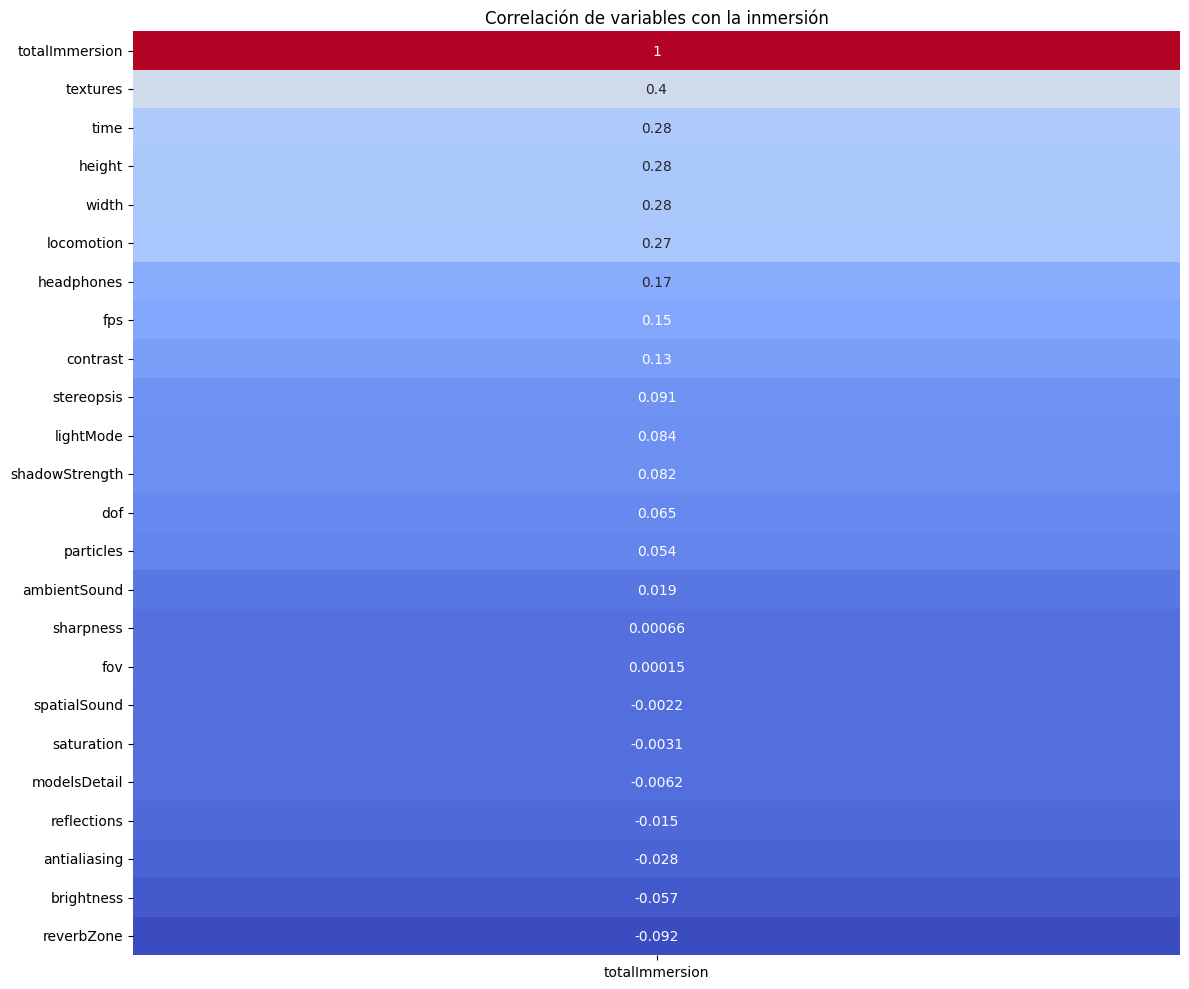

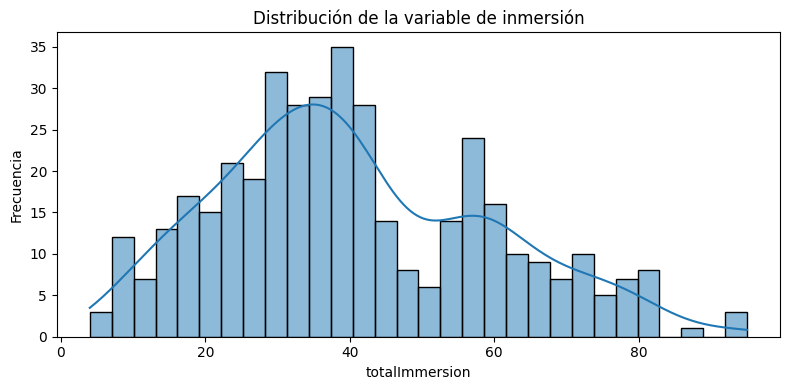

In [ ]:
# Mostrar información general
print("Información del dataset:")
print(df.info())

# Estadísticas descriptivas
print("\nResumen estadístico:")
display(df.describe().round(2))

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Matriz de correlación con la variable objetivo
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['totalImmersion']].sort_values(by='totalImmersion', ascending=False),
            annot=True, cmap='coolwarm', cbar=False)
plt.title("Correlación de variables con la inmersión")
plt.tight_layout()
plt.show()

print("\n")
# Distribución de la variable objetivo
plt.figure(figsize=(8, 4))
sns.histplot(df['totalImmersion'], kde=True, bins=30)
plt.title("Distribución de la variable de inmersión")
plt.xlabel("totalImmersion")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


## XGBoost

In [ ]:
# --- 1. Definir el ESPACIO DE BÚSQUEDA
search_spaces = {
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 15),
    'gamma': Real(0, 5, 'uniform'),      # Un número real entre 0 y 5
    'learning_rate': Categorical([0.01, 0.1]) # Una elección entre estas categorías
}

# --- 2. Configurar y Ejecutar BayesSearchCV ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_spaces,
    n_iter=380, #cuántas combinaciones diferentes vamos a probar
    scoring='neg_root_mean_squared_error',
    cv=5,                                    # Numero de folds a aplicar
    verbose=2,                               # Para que imprima el progreso. 0 es silencio, 1 poco, 2 detallado.
    n_jobs=-1,
    random_state=42
)
start_time = time.time() # Tiempo de inicio de la ejecución

print("Iniciando la búsqueda inteligente con BayesSearchCV.")
bayes_search.fit(X_train_scaled, y_train)
print("¡Búsqueda finalizada!\n")

end_time = time.time()# Tiempo de fin de la ejecución
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


# --- 3. Revisar los Resultados ---
print(f"Los mejores parámetros encontrados son: {bayes_search.best_params_}")
best_rmse = -bayes_search.best_score_ #RMSE obtenido durante la validación cruzada
print(f"Mejor RMSE (cross-validation): {best_rmse:.4f}\n")

# Obtener el mejor modelo, ya re-entrenado
best_model = bayes_search.best_estimator_

# Evaluar el rendimiento final en el conjunto de prueba
print("Evaluando el mejor modelo en el conjunto de prueba.")
predictions = best_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE en el conjunto de prueba: {final_rmse:.4f}")

Iniciando la búsqueda inteligente con BayesSearchCV.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fit

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(3), np.int64(12)] before, using random point [1.135550191228544, 0.01, np.int64(3), np.int64(11)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(3), np.int64(1)] before, using random point [1.1566291020608634, 0.01, np.int64(9), np.int64(1)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(3), np.int64(1)] before, using random point [4.007086850420253, 0.01, np.int64(3), np.int64(7)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(3), np.int64(1)] before, using random point [2.2389507475641635, 0.1, np.int64(6), np.int64(6)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(3), np.int64(1)] before, using random point [2.7276500359442557, 0.01, np.int64(9), np.int64(7)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [1.9042148145840403, 0.01, np.int64(9), np.int64(10)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.1094958893603524, 0.1, np.int64(9), np.int64(2)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.8276129067062654, 0.1, np.int64(6), np.int64(3)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.580586383009234, 0.01, np.int64(6), np.int64(1)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.2632174646595393, 0.1, np.int64(9), np.int64(8)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [4.1967652852195485, 0.1, np.int64(10), np.int64(4)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [3.526945112380538, 0.1, np.int64(9), np.int64(2)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.8774798177240206, 0.1, np.int64(5), np.int64(9)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [3.945906570790477, 0.1, np.int64(5), np.int64(11)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [1.503047150789034, 0.01, np.int64(9), np.int64(4)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [0.21568481234410466, 0.1, np.int64(3), np.int64(4)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [1.1769997832797854, 0.1, np.int64(8), np.int64(3)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.852342751822164, 0.1, np.int64(10), np.int64(14)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [1.6667049881526916, 0.1, np.int64(7), np.int64(4)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [4.285841877791286, 0.01, np.int64(8), np.int64(8)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [0.8009862476244474, 0.1, np.int64(9), np.int64(3)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [4.555910614638008, 0.1, np.int64(7), np.int64(11)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [2.435437982203364, 0.1, np.int64(6), np.int64(14)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [0.07410153234166107, 0.01, np.int64(9), np.int64(9)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, np.float64(0.1), np.int64(9), np.int64(13)] before, using random point [0.8273868475250596, 0.1, np.int64(9), np.int64(2)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [42]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         random_state=42,
                         max_depth=9,
                         min_child_weight=13,
                         gamma=5,
                         learning_rate=0.1)


xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
y_pred = xgb_model.predict(X_test_scaled)

print(y_pred)

[30.957794 43.787167 31.043207 27.569683 19.807667 42.177986 44.76444
 41.953    61.880596 45.489586 42.74734  24.262743 42.450966 66.380974
 58.377644 11.990754 51.431114 28.570349 41.226997 33.486473 41.913097
 26.121428 30.176073 37.029366 61.388134 22.437159 42.75128  23.112707
 34.38752  45.030094 28.219267 33.01214  41.70054  45.55321  47.877018
 24.995363 50.613205 42.640068 31.079144 23.774464 59.69108  62.087616
 32.24325  31.78394  37.489143 32.634018 28.025175 21.51793  57.54422
 38.39251  29.183788 38.484562 45.892136 26.377445 23.287647 33.612877
 34.043846 47.44883  35.591915 24.994608 13.710119 62.62962  24.276608
 36.179756 73.092636 26.894178 47.472305 35.209538 56.971844 27.984947
 42.8013   52.088093 41.688606 29.37034  43.531036 27.775047 40.20886
 21.855331 48.625057 29.301691 52.849983]


### Métricas desempeño XGBoost

In [44]:
# Calculo del MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"El Error Absoluto Medio (MAE) es: {mae}")

El Error Absoluto Medio (MAE) es: 12.412591934204102


In [45]:
# Calculo de la Raíz del Error Cuadrático Medio (RMSE).
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 15.38


In [46]:
# Calculo del Error Cuadrático Medio (MSE).
mse = mean_squared_error(y_test, y_pred)
print(f"\nError Cuadrático Medio (MSE) en el conjunto de prueba: {mse:.4f}")


Error Cuadrático Medio (MSE) en el conjunto de prueba: 236.4437


## SHAP

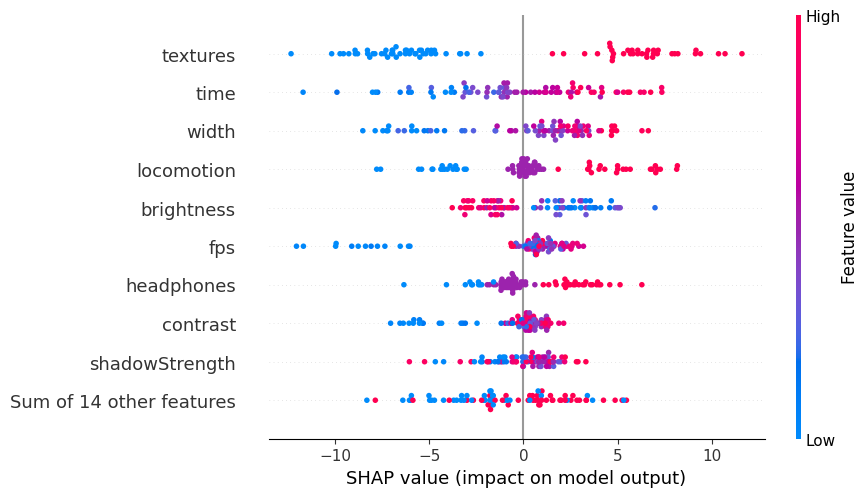

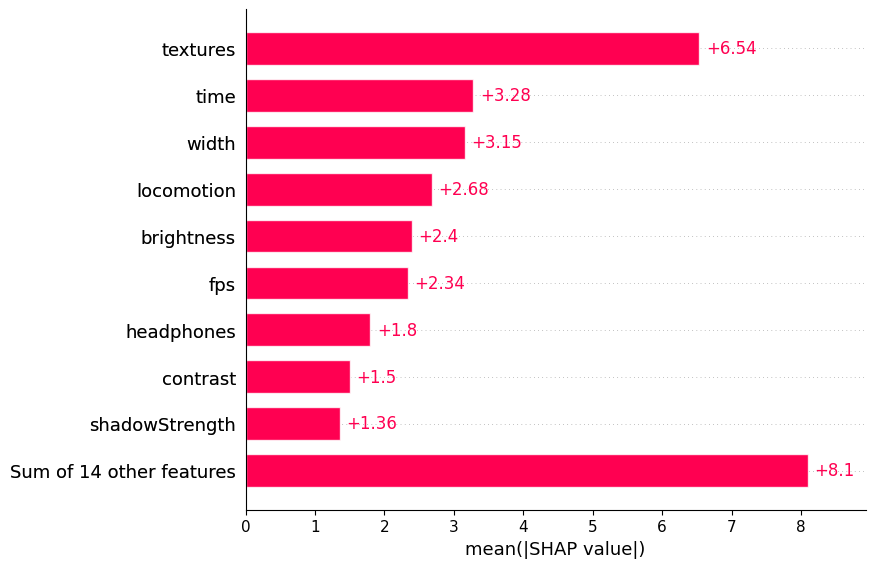

In [47]:
feature_names = X.columns.tolist()

# Convertir los arrays escalados a DataFrame con nombres de columnas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Crear el explainer con el modelo entrenado y los datos con nombres
explainer = shap.Explainer(xgb_model, X_train_scaled_df)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test_scaled_df)
plt.figure(figsize=(20, 10))
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('shap_beeswarm_poster.pdf', bbox_inches='tight')

print("\n")
plt.figure(figsize=(8, 10))
shap.plots.bar(shap_values, show=False)
plt.savefig('shap_barplot_poster.pdf', bbox_inches='tight')


